# 📘 Using Union with Jupyter Notebooks

You can interact with Union using the `UnionRemote` object, which
is a client that exposes several methods for you to programmatically:

1. Register tasks and workflows
2. Execute tasks and workflows
3. Fetch and inspect task and workflow outputs

In this notebook, we'll grab the model that we trained in the previous step.

## Initializing `UnionRemote`

We first initialize a `UnionRemote` object with the configuration needed
to access objects from Union Serverless.

In [1]:
from union.remote import UnionRemote

remote = UnionRemote()

## Fetching a Workflow Execution

To fetch the workflow execution artifacts, replace the `execution_id = <REPLACE_ME>`
variable with the unique execution id created by Union.

For example, after running the `union run` command,
the execution id can be found in the URL:

```
Go to https://sandbox.union.ai/console/projects/flytesnacks/domains/development/executions/<EXECUTION_ID> to see execution in the console.
```

In [ ]:
execution_id = "<REPLACE_ME>"
execution = remote.fetch_execution(name=execution_id)
remote.sync(execution, sync_nodes=True)

# get execution output keys
execution.outputs.keys()

As you can see, `execution.outputs` is a dict-like object with a single
key `"o0"`, which we can use to access the sklearn model object we just
trained.

In [3]:
from sklearn.linear_model import LogisticRegression

model = execution.outputs.get("o0", as_type=LogisticRegression)
model

LogisticRegression(max_iter=1000)

We can now use this model just like any other estimator to generate predictions:

In [4]:
from sklearn.datasets import load_wine
from sklearn.metrics import accuracy_score

data = load_wine(as_frame=True).frame
target = data["target"]
features = data.drop("target", axis="columns")

predictions = model.predict(features)
accuracy_score(target, predictions)

0.7191011235955056

## Fetching Intermediate Results

You can also fetch intermediate results of the tasks in our workflow. For example, if we want to visualize the difference in distribution of class targets between our raw processed data, we can do the following:

In [5]:
execution.node_executions.keys()

dict_keys(['end-node', 'n0', 'n1', 'n2', 'start-node'])

As you can see, Union has implicit `start-node` and `end-node` nodes that mark
the beginning and end of a workflow, respectively.

You can see that it also has `n*` nodes to represent tasks nodes in between. We know
that the `get_data` task was the `0th` node and the `process_data` task was the
`1st` node in our workflow:

In [6]:
import pandas as pd

# get raw data
raw_data = execution.node_executions["n0"].outputs["o0"]
raw_data = raw_data.open(pd.DataFrame).all()

# get processed data
processed_data = execution.node_executions["n1"].outputs["o0"]
processed_data = processed_data.open(pd.DataFrame).all()

Then, we simply plot the classes to see that we successfully aggregated
class `1` and `2` to a single class of `1`.

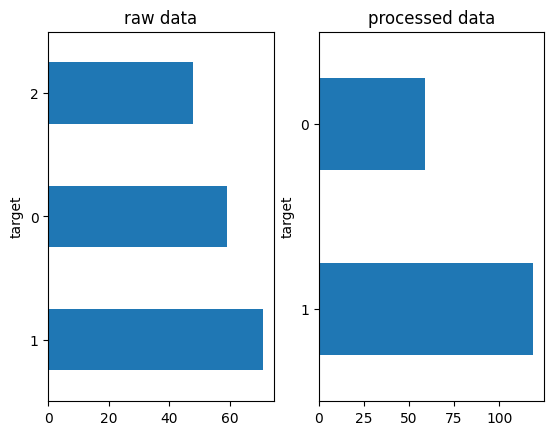

In [8]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(1, 2)
raw_data["target"].value_counts().plot.barh(ax=axes[0], title="raw data")
processed_data["target"].value_counts().plot.barh(ax=axes[1], title="processed data");

## Executing a Workflow with `UnionRemote`

Finally, you can execute a workflow from a Python runtime like so:

In [9]:
workflow_name = "workflows.union_workflow.training_workflow"
workflow = remote.fetch_workflow(name=workflow_name)
execution = remote.execute(workflow, inputs={})
print(f"Go to {remote.generate_console_url(execution)} to see execution in the console.")

Go to https://serverless.union.ai/org/cosmicbboy/projects/flytesnacks/domains/development/executions/ad6nwhx52zztdm4hnx58 to see execution in the console.
